First the necessary python packages are imported

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report, roc_curve)
from mpl_toolkits.mplot3d import Axes3D
from helper_functions import *

### Random Seed
Fix the numpy random seed for repeatable results.

In [2]:
np.random.seed(42)
tf.random.set_seed(42)


### Helper functions

Additional functions are defined in the helper functions file (helper_functions.py)

### Loading the dataset

Now the dataset is loaded.
Default location (for me) is in DataFiles folder (located in current directory) 

So file path is ./DataFiles/Mg22_alphaalpha_digiSim.h5

In [3]:
#URL for downloading from the Machine Learning ECT github (somehow does not work)
#f.close()
#data_origin_MLECT = 'https://github.com/NuclearTalent/MachineLearningECT/raw/master/doc/ProjectsExercises/2020/ProjectAT/pdf/Mg22_alphaalpha_digiSim.h5'
#MLECT_path = tf.keras.utils.get_file('Mg22_alphaalpha_digiSim.h5', origin=data_origin_MLECT)
#f=h5py.File(MLECT_path, 'r') 

In [3]:
#Open the local file
local_data='./DataFiles/Mg22_alphaalpha_digiSim.h5'
f=h5py.File(local_data, 'r')
#print(f.keys())
print(f['Event_[0]'])
#AllEvents = np.zeros (len(f.keys()))
   

<HDF5 dataset "Event_[0]": shape (24,), type "|V48">


Now we load the data into a simple list. This list has three indices [event number][pad fired][data column]

with event number in [0,1999], pad fired in [0,x] with x variable for each event, data column in [0,5] (x,y,z,T,A,zeros)


The last data column contains only zeroes and can be removed to reduce data size

 ### Labeling and cleaning
 The events came labeled, with even nr events = reaction (label 1), odd nr events = beam (label 0)
 
 We also remove empty events (384, 430,484,914,1204 (numbers correspond to keys))
 
Before moving on we label the data and then split it into training, validation and test (only generating indices)
We also remove the empty events and label thes correctly

In [4]:

AllData, Labels = load_data(f)

x_idx = np.arange(len(AllData))
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)
print("Dataset was divided into " + str(len(train_idx)) + " training events, " + str(len(val_idx)) + " validation events and " + str(len(test_idx)) + " test events")
    

Dataset contains 2000 events
Data contains 5 empty events, of indexes: [384, 430, 484, 914, 1204]

Dataset contains 1995 non-empty events:
995 Beam Events, and 1000 Reaction Events

Dataset was divided into 1615 training events, 180 validation events and 200 test events


### Raw event visualization
We plot a few events using the helper function plot_3d_event to get an idea of beam and reaction events.

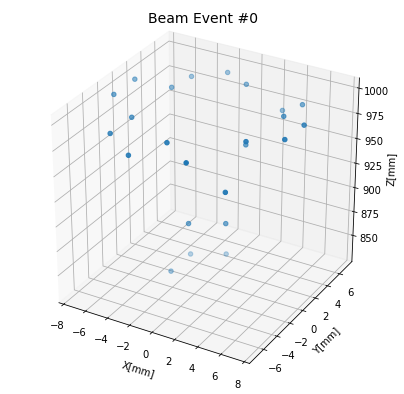

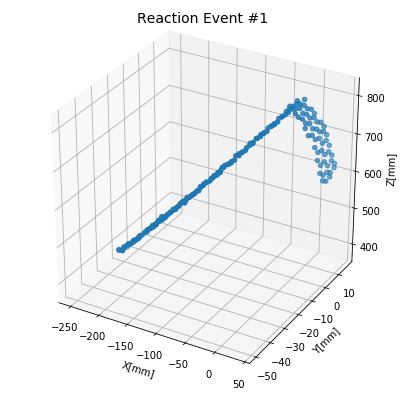

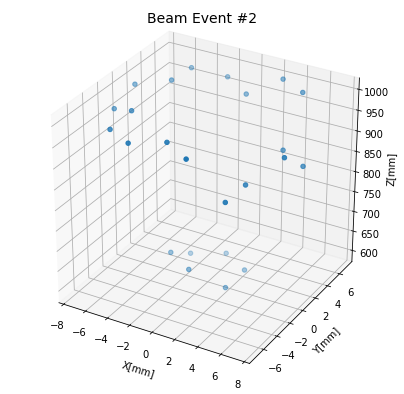

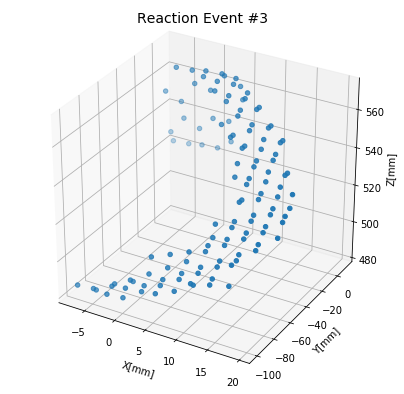

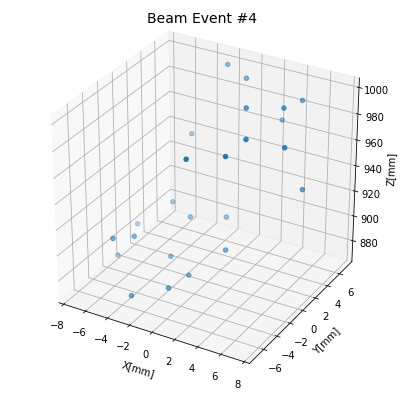

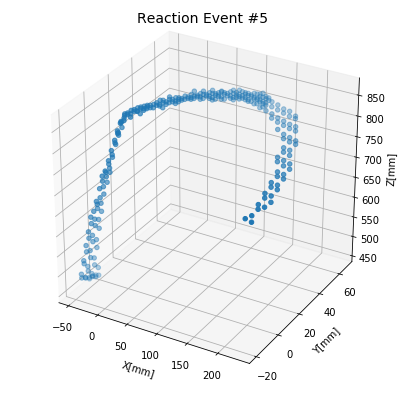

In [5]:
plot_3d_event(AllData,Labels,0)
plot_3d_event(AllData,Labels,1)
plot_3d_event(AllData,Labels,2)
plot_3d_event(AllData,Labels,3)
plot_3d_event(AllData,Labels,4)
plot_3d_event(AllData,Labels,5)


### Simple Characteristics
Now let's try to visualize simple characteristics, average x, average y, average z and sum of A for each event
Also number of pads fired per event

2nd version: replacing average x, average y by standard deviation x, standard deviation y. 

In [6]:
MeanXPerEvent = np.zeros(len(AllData))
MeanYPerEvent = np.zeros(len(AllData))
MeanZPerEvent = np.zeros(len(AllData))
SumAPerEvent = np.zeros(len(AllData))
PadsPerEvent = np.zeros(len(AllData))
MeanWeightedXPerEvent = np.zeros(len(AllData))
MeanWeightedYPerEvent = np.zeros(len(AllData))
StDevXPerEvent = np.zeros(len(AllData))
StDevYPerEvent = np.zeros(len(AllData))
StDevZPerEvent = np.zeros(len(AllData))
FracClosePtsPerEvent = np.zeros(len(AllData)) # fraction of points satisfying x^2+y^2<100 in event



for i in range(len(AllData)):

    for j in range(len(AllData[i])):
        MeanXPerEvent[i] = MeanXPerEvent[i] + AllData[i][j][0]
        MeanYPerEvent[i] = MeanYPerEvent[i] + AllData[i][j][1]
        MeanZPerEvent[i] = MeanZPerEvent[i] + AllData[i][j][2]
        SumAPerEvent[i] = SumAPerEvent[i] + AllData[i][j][4]
        MeanWeightedXPerEvent[i] = MeanWeightedXPerEvent[i] + AllData[i][j][0]*AllData[i][j][4]
        MeanWeightedYPerEvent[i] = MeanWeightedYPerEvent[i] + AllData[i][j][1]*AllData[i][j][4]
        if (AllData[i][j][0]**2 + AllData[i][j][1]**2 < 100):
            FracClosePtsPerEvent[i] = FracClosePtsPerEvent[i] + 1 
        
    
    MeanXPerEvent[i] = MeanXPerEvent[i]/len(AllData[i])
    MeanYPerEvent[i] = MeanYPerEvent[i]/len(AllData[i])
    MeanZPerEvent[i] = MeanZPerEvent[i]/len(AllData[i])
    MeanWeightedXPerEvent[i] = MeanWeightedXPerEvent[i]/len(AllData[i])
    MeanWeightedYPerEvent[i] = MeanWeightedYPerEvent[i]/len(AllData[i])
    FracClosePtsPerEvent[i] = FracClosePtsPerEvent[i]/len(AllData[i])
    
    #second for loop for calculation of standard deviation
    for j in range(len(AllData[i])):
        StDevXPerEvent[i] = StDevXPerEvent[i] + (AllData[i][j][0]-MeanXPerEvent[i])**2
        StDevYPerEvent[i] = StDevYPerEvent[i] + (AllData[i][j][1]-MeanYPerEvent[i])**2
        StDevZPerEvent[i] = StDevZPerEvent[i] + (AllData[i][j][2]-MeanZPerEvent[i])**2
   
    StDevXPerEvent[i] = np.sqrt(StDevXPerEvent[i])/(len(AllData[i])-1)
    StDevYPerEvent[i] = np.sqrt(StDevYPerEvent[i])/(len(AllData[i])-1)
    StDevZPerEvent[i] = np.sqrt(StDevZPerEvent[i])/(len(AllData[i])-1)
    
    
        
    
    
    PadsPerEvent[i] = len(AllData[i])
    
print(SumAPerEvent)
print(MeanXPerEvent)      

[ 41292.86413493 322786.82279782  89094.2067578  ...  37851.88599835
  45542.97047786 260079.24714189]
[-3.33786011e-06 -6.60346445e+01 -3.33786011e-06 ... -4.39459217e+00
 -3.33786011e-06 -4.74462833e+00]


### Visualising the features
Now we create some 2d plots and histograms to view the data.

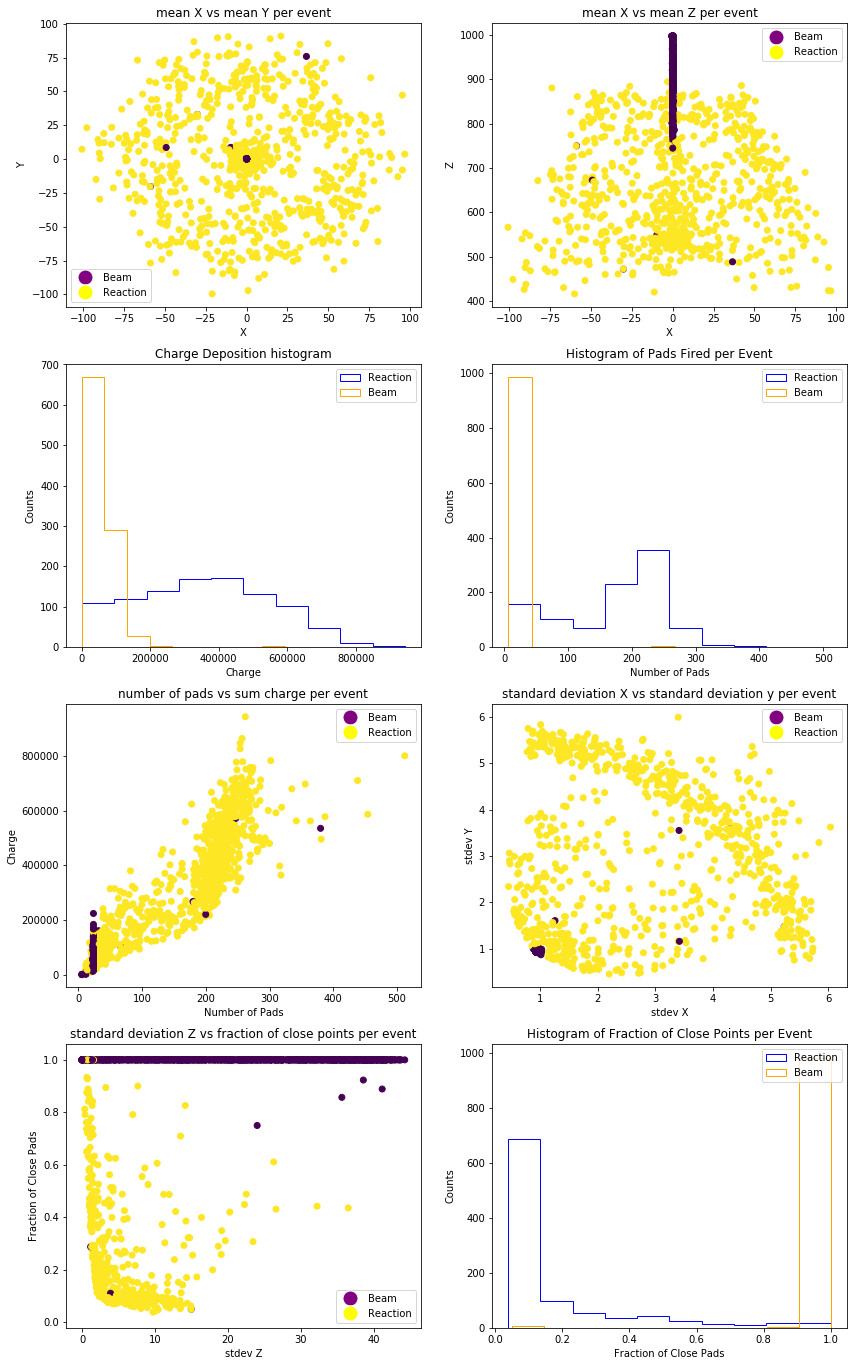

In [7]:
fig, ax = plt.subplots(4, 2, figsize=(14, 24))

#define legend for 2d plots
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Beam', markerfacecolor='purple', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Reaction', markerfacecolor='yellow', markersize=15)]

ax[0][0].scatter(MeanXPerEvent[train_idx],MeanYPerEvent[train_idx], c = Labels[train_idx])
ax[0][0].set_title("mean X vs mean Y per event")
ax[0][0].set_xlabel("X")
ax[0][0].set_ylabel("Y")
ax[0][0].legend(handles=legend_elements)

ax[0][1].scatter(MeanXPerEvent[train_idx],MeanZPerEvent[train_idx], c = Labels[train_idx])
ax[0][1].set_title("mean X vs mean Z per event")
ax[0][1].set_xlabel("X")
ax[0][1].set_ylabel("Z")
ax[0][1].legend(handles=legend_elements)

ax[1][0].hist(SumAPerEvent[Labels>0.5], color='blue', label = 'Reaction', histtype = 'step')
ax[1][0].hist(SumAPerEvent[Labels<0.5], color='orange', label = 'Beam', histtype = 'step')
ax[1][0].set_title("Charge Deposition histogram")
ax[1][0].set_xlabel("Charge")
ax[1][0].set_ylabel("Counts")
ax[1][0].legend()

ax[1][1].hist(PadsPerEvent[Labels>0.5], color='blue', label = 'Reaction', histtype = 'step')
ax[1][1].hist(PadsPerEvent[Labels<0.5], color='orange', label = 'Beam', histtype = 'step')
ax[1][1].set_title("Histogram of Pads Fired per Event")
ax[1][1].set_xlabel("Number of Pads")
ax[1][1].set_ylabel("Counts")
ax[1][1].legend()

ax[2][0].scatter(PadsPerEvent[train_idx],SumAPerEvent[train_idx], c = Labels[train_idx])
ax[2][0].set_title("number of pads vs sum charge per event")
ax[2][0].set_xlabel("Number of Pads")
ax[2][0].set_ylabel("Charge")
ax[2][0].legend(handles=legend_elements)

ax[2][1].scatter(StDevXPerEvent[train_idx],StDevYPerEvent[train_idx], c = Labels[train_idx])
ax[2][1].set_title("standard deviation X vs standard deviation y per event")
ax[2][1].set_xlabel("stdev X")
ax[2][1].set_ylabel("stdev Y")
ax[2][1].legend(handles=legend_elements)

ax[3][0].scatter(StDevZPerEvent[train_idx],FracClosePtsPerEvent[train_idx], c = Labels[train_idx])
ax[3][0].set_title("standard deviation Z vs fraction of close points per event")
ax[3][0].set_xlabel("stdev Z")
ax[3][0].set_ylabel("Fraction of Close Pads")
ax[3][0].legend(handles=legend_elements)

ax[3][1].hist(FracClosePtsPerEvent[Labels>0.5], color='blue', label = 'Reaction', histtype = 'step')
ax[3][1].hist(FracClosePtsPerEvent[Labels<0.5], color='orange', label = 'Beam', histtype = 'step')
ax[3][1].set_title("Histogram of Fraction of Close Points per Event")
ax[3][1].set_xlabel("Fraction of Close Pads")
ax[3][1].set_ylabel("Counts")
ax[3][1].legend()









### Visualizing the outliers

Looking at the previous plots, one notes a few reaction events that behave very much as beam events.
We find and plot them here.

[280, 499, 1098, 1711]


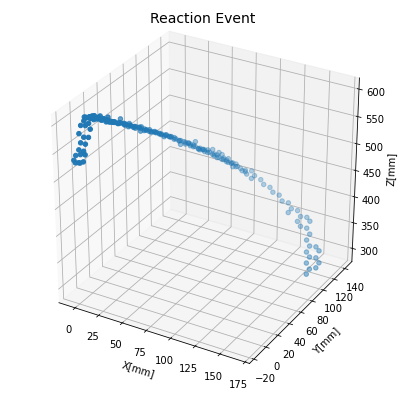

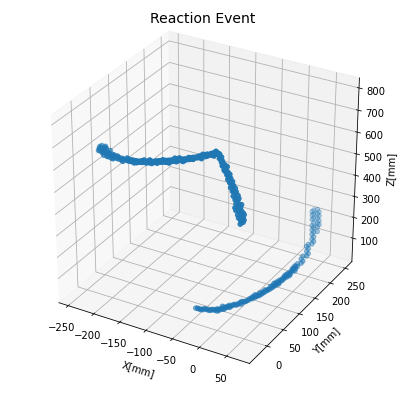

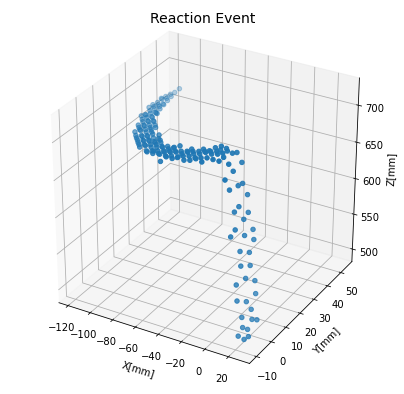

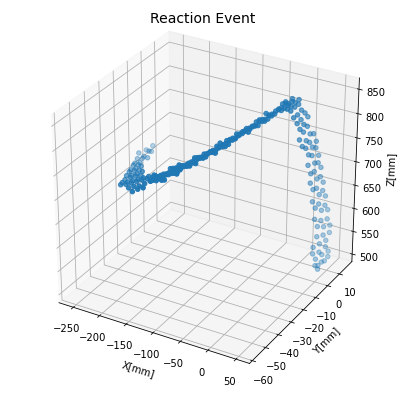

In [9]:
large_x_stdev = train_idx[StDevXPerEvent[train_idx]>3]
large_z_stdev = train_idx[StDevZPerEvent[train_idx]>20]
small_frac_close = train_idx[FracClosePtsPerEvent[train_idx]<0.4]
#possible_outliers = list(large_x_stdev & large_z_stdev) 
#print(large_x_stdev)
#print(large_z_stdev)
intersection1 = np.intersect1d(large_x_stdev,small_frac_close)
#print(intersection1)
Outliers = []
#print(possible_outliers)
#for i in range(len(small_frac_close)):
#    if (Labels[small_frac_close[i]]==1):
#        Outliers.append(small_frac_close[i])

for i in range(len(intersection1)):
    if (Labels[intersection1[i]]==1):
        Outliers.append(intersection1[i])

#for i in range(len(large_x_stdev)):
#    if (Labels[large_x_stdev[i]]==1):
#        Outliers.append(large_x_stdev[i])

print(Outliers)
for i in range(len(Outliers)):
    plot_3d_event(AllData,Labels,Outliers[i])
    #print(FracClosePtsPerEvent[Outliers[i]])

    


### Merging
Now we merge these data into features and labels.

In [10]:
xSimple = np.zeros((len(AllData),5))

for i in range(len(AllData)):
    #standard x and y
    #xSimple[i][0] = MeanXPerEvent[i]
    #xSimple[i][1] = MeanYPerEvent[i]
    xSimple[i][0] = MeanZPerEvent[i]
    #alternative x and y
    xSimple[i][1] = StDevXPerEvent[i]
    #xSimple[i][1] = StDevYPerEvent[i]
    #xSimple[i][5] = StDevZPerEvent[i]
    xSimple[i][3] = SumAPerEvent[i]
    xSimple[i][4] = PadsPerEvent[i]
    xSimple[i][2] = FracClosePtsPerEvent[i]

xSimple_train = xSimple[train_idx][:]
xSimple_val = xSimple[val_idx][:]
xSimple_test = xSimple[test_idx][:]
Labels_train = Labels[train_idx]
Labels_val = Labels[val_idx]
Labels_test = Labels[test_idx]

#ar_nan = np.where(np.isnan(xSimple))
#print (ar_nan)
#ar_inf = np.where(np.isinf(xSimple))
#print (ar_inf)
#ar_neginf = np.where(np.isneginf(xSimple))
#print (ar_neginf)

print(xSimple[1204,:])


[6.32156250e+02 7.22232394e-01 3.28125000e-01 1.72528081e+05
 6.40000000e+01]


### Logistic Regression
Now let us try a few simple models on the parameters obtained above. We start with a logistic regression model, as imported from sklearn.

Model performance for training set:
--------------------------------------------------------

Accuracy: 0.9578947368421052
Precision: 0.928082191780822
Recall: 0.9938875305623472
F1-score: 0.9598583234946872
MCC: 0.9180729905117835


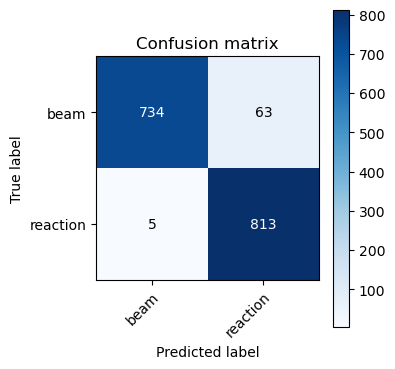


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9666666666666667
Precision: 0.9456521739130435
Recall: 0.9886363636363636
F1-score: 0.9666666666666666
MCC: 0.9342885375494071


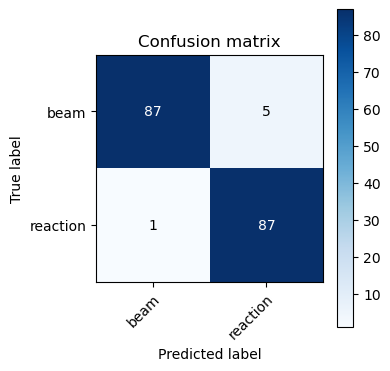

In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(xSimple_train, Labels_train)
#print("validation set accuracy: {:.3f}".format(logreg.score(xSimple_val,Labels_val)))

LR0_pred_train = logreg.predict(xSimple_train)
LR0_pred_val = logreg.predict(xSimple_val)

print_model_performance(Labels_train,LR0_pred_train,"training")
print_model_performance(Labels_val,LR0_pred_val,"validation")


Another try using StandardScaler to get scaled data.

Model performance for training set:
--------------------------------------------------------

Accuracy: 0.9969040247678018
Precision: 1.0
Recall: 0.9938875305623472
F1-score: 0.996934396076027
MCC: 0.9938265564282749


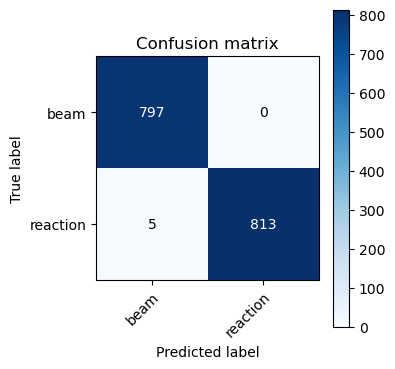


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9944444444444445
Precision: 1.0
Recall: 0.9886363636363636
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


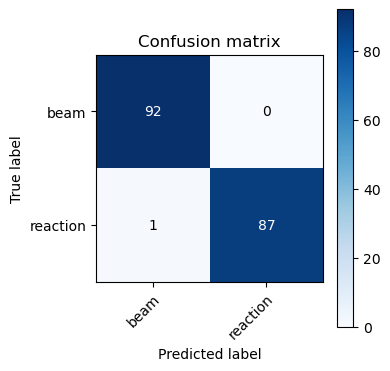

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(xSimple_train)
scaler_mm = MinMaxScaler()
scaler_mm.fit(xSimple_train)

#Using the standardscaler
xSimple_train_stsc = scaler.transform(xSimple_train)
xSimple_val_stsc = scaler.transform(xSimple_val)

#Using the minmaxscaler
#xSimple_train_stsc = scaler_mm.transform(xSimple_train)
#xSimple_val_stsc = scaler_mm.transform(xSimple_val)

#Without using any scaling
#xSimple_train_stsc = xSimple_train
#xSimple_val_stsc = xSimple_val

logreg2 = LogisticRegression()
logreg2.fit(xSimple_train_stsc, Labels_train)
#print("validation set accuracy: {:.3f}".format(logreg2.score(xSimple_val_stsc,Labels_val)))

LR_pred_train = logreg2.predict(xSimple_train_stsc)
LR_pred_val = logreg2.predict(xSimple_val_stsc)

print_model_performance(Labels_train,LR_pred_train,"training")
print_model_performance(Labels_val,LR_pred_val,"validation")

### Random Forest
Here a random forest is used for classification. Grid search is used for optimisation of the parameters

{'bootstrap': True, 'max_features': 4, 'n_estimators': 6}
RandomForestClassifier(max_features=4, n_estimators=6)
[(0.802474171126164, 'z'), (0.1520330522987665, 'nrofpads'), (0.040519059834298675, 'x'), (0.003337563398257221, 'y'), (0.0016361533425136136, 'charge')]
Model performance for training set:
--------------------------------------------------------

Accuracy: 0.9975232198142415
Precision: 1.0
Recall: 0.9951100244498777
F1-score: 0.9975490196078431
MCC: 0.9950581319705346


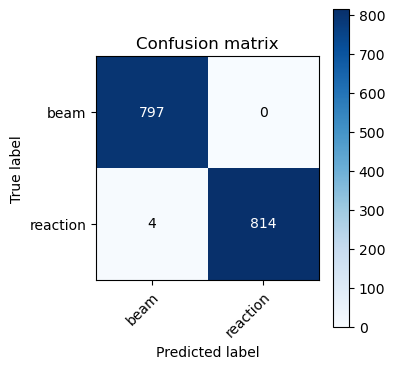


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9944444444444445
Precision: 1.0
Recall: 0.9886363636363636
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


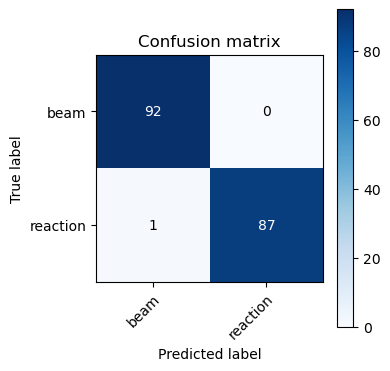

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#RFC = RandomForestClassifier()
#RFC.fit(xSimple_train_stsc, Labels_train)

#RFC_pred_train = RFC.predict(xSimple_train_stsc)
#RFC_mse_train = mean_squared_error(Labels_train, RFC_pred_train)
#RFC_rmse_train = np.sqrt(RFC_mse_train)
#print('random forest rmse of training data is: ', RFC_rmse_train)

#scores = cross_val_score(RFC, xSimple_train_stsc, Labels_train, scoring="neg_mean_squared_error", cv=10)
#RFC_scores = np.sqrt(-scores)
#display_scores(RFC_scores)


param_grid = [
{'n_estimators': [3, 4,5,6], 'max_features': [2,3,4,5], 'bootstrap': [False,True]},
]
scoring = 'precision_macro'
scoring = 'recall_macro'
scoring='neg_mean_squared_error'
RFC = RandomForestClassifier()
grid_search_imp = GridSearchCV(RFC, param_grid, cv=5, scoring=scoring)
grid_search_imp.fit(xSimple_train_stsc, Labels_train)
print(grid_search_imp.best_params_)
print(grid_search_imp.best_estimator_)

cvres = grid_search_imp.cv_results_
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    #print(np.sqrt(-mean_score), params)

feature_importances = grid_search_imp.best_estimator_.feature_importances_
print(sorted(zip(feature_importances, ["x","y","z","charge","nrofpads"]), reverse=True))

RFC_best = grid_search_imp.best_estimator_
RFC_pred_train = RFC_best.predict(xSimple_train_stsc)
RFC_pred_val = RFC_best.predict(xSimple_val_stsc)
#forest_mse_imp_final = mean_squared_error(trdata_labels, deaths_predictions_forest_final)
#forest_rmse_imp_final = np.sqrt(forest_mse_imp_final)
#print('random forest rmse (final version) of training data is: ', forest_rmse_imp)


print_model_performance(Labels_train,RFC_pred_train,"training")
print_model_performance(Labels_val,RFC_pred_val,"validation")

### Dense Neural Network
Now we try a dense neural network on these simple features

In [14]:
# Init the Sequential model
model = tf.keras.Sequential()
# Add Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(xSimple_train_stsc.shape[1],)))

# Add hidden layer
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))


# Add output layer.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Finally, compile the model and print a summary. Loss function and optimizer is set during compilation.
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,737
Non-trainable params: 128
_________________________________________________________________


#### Training DNN
Now we train the neural network


In [15]:
# Set parameters for the training run. The full data set is only 2000x5 doubles so large nr of epochs and
# small batch_size will still work well even on cpu
epochs = 20
batch_size = 16

Now the DNN is trained using the standardscaled data.

In [16]:
# The validation_data keywork expects a 'tuple' (val_x, val_y) so we make one on the fly
history = model.fit(
    x=xSimple_train_stsc,
    y=Labels_train,
    validation_data=(xSimple_val_stsc, Labels_val),
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/20
101/101 [==============================] - 0s 4ms/step - loss: 0.0898 - accuracy: 0.9814 - val_loss: 0.1466 - val_accuracy: 0.9944
Epoch 2/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0297 - accuracy: 0.9938 - val_loss: 0.0625 - val_accuracy: 0.9944
Epoch 3/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0361 - accuracy: 0.9938 - val_loss: 0.0435 - val_accuracy: 0.9944
Epoch 4/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.9963 - val_loss: 0.0442 - val_accuracy: 0.9944
Epoch 5/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0229 - accuracy: 0.9969 - val_loss: 0.0417 - val_accuracy: 0.9944
Epoch 6/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.9969 - val_loss: 0.0492 - val_accuracy: 0.9944
Epoch 7/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.9963 - val_loss: 0.0450 - val_accuracy: 0.9944
Epoch 

#### Visualisation of results

Model performance for training set:
--------------------------------------------------------

Accuracy: 0.9969040247678018
Precision: 1.0
Recall: 0.9938875305623472
F1-score: 0.996934396076027
MCC: 0.9938265564282749


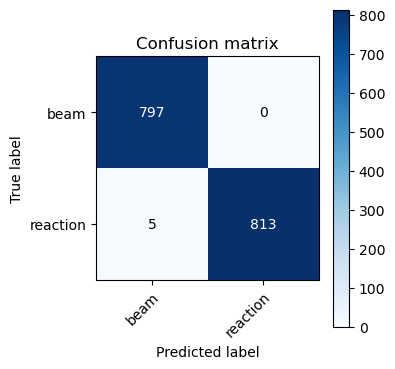


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9944444444444445
Precision: 1.0
Recall: 0.9886363636363636
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


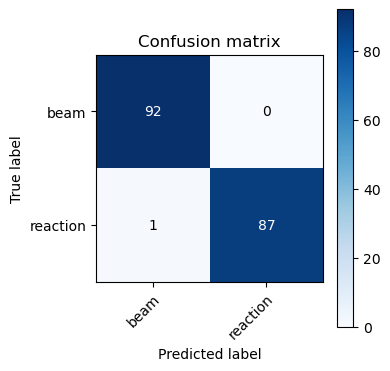

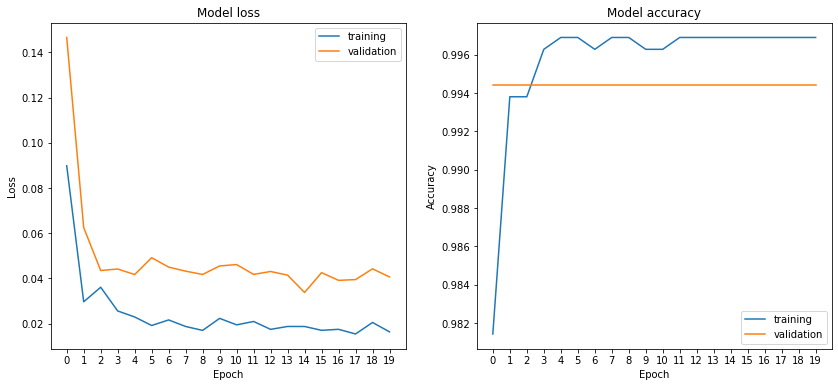

In [17]:
# Plot loss and val_loss as one plot, and accuracy and val_accuracy as another, side-by-side.
# We'll also save this plot as plot_history() in the helper_functions file, so any time we need to
# plot the history object like this we can just call that function and pass the history object as
# an argument.


#the _pre contain a number in [0,1] these get mapped to 1 if >0.5 and to 0 if <0.5
DNN_pred_train_pre = model.predict(xSimple_train_stsc)
DNN_pred_val_pre = model.predict(xSimple_val_stsc)
DNN_pred_train = DNN_pred_train_pre > 0.5
DNN_pred_val = DNN_pred_val_pre > 0.5


print_model_performance(Labels_train,DNN_pred_train,"training")
print_model_performance(Labels_val,DNN_pred_val,"validation")


make_nn_plots(history)



### K-Means
Here we try k-means to separate beam from reaction events

[1 0 1 ... 1 0 1]
Model performance for training set:
--------------------------------------------------------

Accuracy: 0.9102167182662538
Precision: 0.8523560209424084
Recall: 0.9951100244498777
F1-score: 0.9182177100958826
MCC: 0.8321274122959206


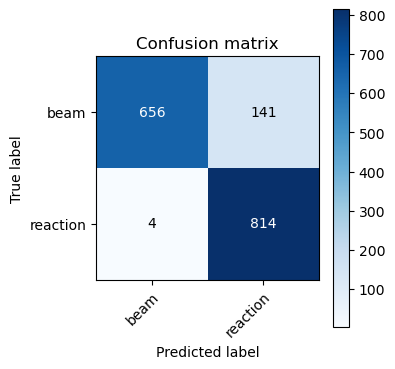


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9166666666666666
Precision: 0.8613861386138614
Recall: 0.9886363636363636
F1-score: 0.9206349206349206
MCC: 0.8425728622058198


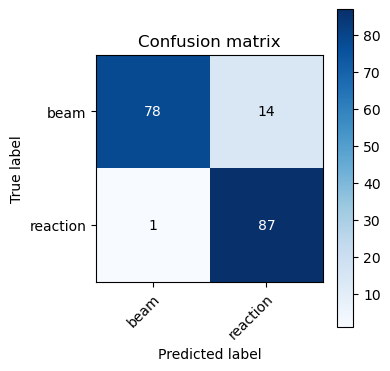

In [18]:
from sklearn.cluster import KMeans
clust = KMeans(n_clusters=2).fit(xSimple_train_stsc)
print(clust.labels_)
KM_pred_train = clust.predict(xSimple_train_stsc)
KM_pred_val = clust.predict(xSimple_val_stsc)

#Now we need to find out which cluster is which type of event
#We select the one that gives best accuracy on training set

accuracy_train_norm = accuracy_score(Labels_train, KM_pred_train)
accuracy_train_swap = accuracy_score(Labels_train, 1-KM_pred_train)

if(accuracy_train_swap>accuracy_train_norm):
    KM_pred_train = 1- KM_pred_train
    KM_pred_val = 1 - KM_pred_val

print_model_performance(Labels_train,KM_pred_train,"training")
print_model_performance(Labels_val,KM_pred_val,"validation")


#### Elbow method for K-Means
Here we look for the optimal number of clusters for kmeans. Even with more clusters than our (2) available classes
we can still assign them each to 1 or 0 based on which mapping gives the best results.

Based on [Geron notebook](https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb)
        (search for 'finding the optimal number of clusters')

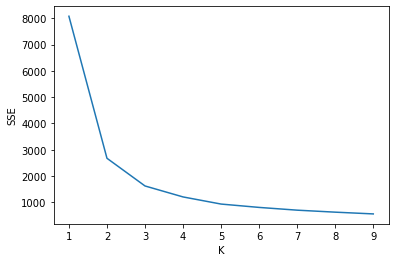

In [19]:
k_rng = range(1,10)
sse = []

for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(xSimple_train_stsc)
    sse.append(km.inertia_)

sse
plt.xlabel('K')
plt.ylabel('SSE') #sum of squared error

plt.plot(k_rng,sse)



Based on elbow method we can use 3 or 5 clusters as well.
Let us try both cases. 
First 3 clusters case.
#### 3-Cluster K-Means 

[2 1 2 ... 2 1 2]
[0.9962848297213622, 0.17956656346749225, 0.6823529411764706, 0.3176470588235294, 0.8204334365325078, 0.0037151702786377707]
Model performance for training set:
--------------------------------------------------------

Accuracy: 0.9962848297213622
Precision: 0.9987714987714987
Recall: 0.9938875305623472
F1-score: 0.9963235294117647
MCC: 0.992581062118398


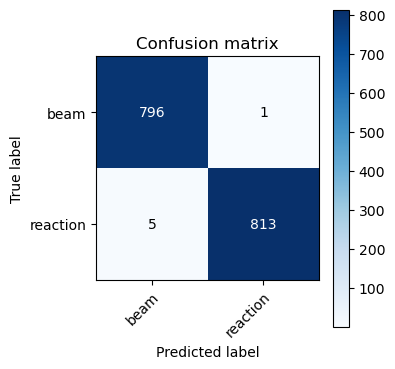


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9944444444444445
Precision: 1.0
Recall: 0.9886363636363636
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


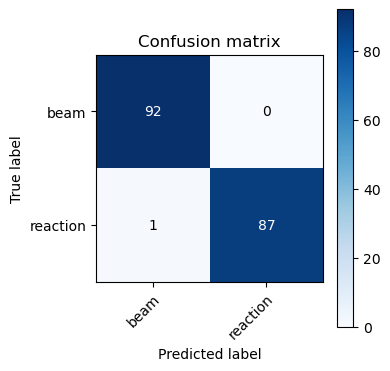

In [20]:
nclusters = 3
clust3 = KMeans(n_clusters=nclusters).fit(xSimple_train_stsc)
print(clust3.labels_)
KM3_pred_train = clust3.predict(xSimple_train_stsc)
KM3_pred_val = clust3.predict(xSimple_val_stsc)

#Now we need to find out which cluster is which type of event
#We select the one that gives best accuracy on training set
#for this we loop over all combinations without trivial ones (all beam or all reaction)
#we denote accuracy_train_010 if cluster 0->0, 1->1 and 2->0

KM3_pred_train_001 = np.zeros(len(KM3_pred_train))
KM3_pred_train_010 = np.zeros(len(KM3_pred_train))
KM3_pred_train_011 = np.zeros(len(KM3_pred_train))
KM3_pred_train_100 = np.zeros(len(KM3_pred_train))
KM3_pred_train_101 = np.zeros(len(KM3_pred_train))
KM3_pred_train_110 = np.zeros(len(KM3_pred_train))
KM3_pred_val_001 = np.zeros(len(KM3_pred_val))
KM3_pred_val_010 = np.zeros(len(KM3_pred_val))
KM3_pred_val_011 = np.zeros(len(KM3_pred_val))
KM3_pred_val_100 = np.zeros(len(KM3_pred_val))
KM3_pred_val_101 = np.zeros(len(KM3_pred_val))
KM3_pred_val_110 = np.zeros(len(KM3_pred_val))

for i in range(len(KM3_pred_train)):
    if (KM3_pred_train[i]==0):
        KM3_pred_train_001[i] = 0
        KM3_pred_train_010[i] = 0
        KM3_pred_train_011[i] = 0
        KM3_pred_train_100[i] = 1
        KM3_pred_train_101[i] = 1
        KM3_pred_train_110[i] = 1
    if (KM3_pred_train[i]==1):
        KM3_pred_train_001[i] = 0
        KM3_pred_train_010[i] = 1
        KM3_pred_train_011[i] = 1
        KM3_pred_train_100[i] = 0
        KM3_pred_train_101[i] = 0
        KM3_pred_train_110[i] = 1
    if (KM3_pred_train[i]==2):
        KM3_pred_train_001[i] = 1
        KM3_pred_train_010[i] = 0
        KM3_pred_train_011[i] = 1
        KM3_pred_train_100[i] = 0
        KM3_pred_train_101[i] = 1
        KM3_pred_train_110[i] = 0
        
for i in range(len(KM3_pred_val)):
    if (KM3_pred_val[i]==0):
        KM3_pred_val_001[i] = 0
        KM3_pred_val_010[i] = 0
        KM3_pred_val_011[i] = 0
        KM3_pred_val_100[i] = 1
        KM3_pred_val_101[i] = 1
        KM3_pred_val_110[i] = 1
    if (KM3_pred_val[i]==1):
        KM3_pred_val_001[i] = 0
        KM3_pred_val_010[i] = 1
        KM3_pred_val_011[i] = 1
        KM3_pred_val_100[i] = 0
        KM3_pred_val_101[i] = 0
        KM3_pred_val_110[i] = 1
    if (KM3_pred_val[i]==2):
        KM3_pred_val_001[i] = 1
        KM3_pred_val_010[i] = 0
        KM3_pred_val_011[i] = 1
        KM3_pred_val_100[i] = 0
        KM3_pred_val_101[i] = 1
        KM3_pred_val_110[i] = 0

        
        

accuracy_train_001 = accuracy_score(Labels_train, KM3_pred_train_001)
accuracy_train_010 = accuracy_score(Labels_train, KM3_pred_train_010)
accuracy_train_011 = accuracy_score(Labels_train, KM3_pred_train_011)
accuracy_train_100 = accuracy_score(Labels_train, KM3_pred_train_100)
accuracy_train_101 = accuracy_score(Labels_train, KM3_pred_train_101)
accuracy_train_110 = accuracy_score(Labels_train, KM3_pred_train_110)

KM3_tr_acc_list = [accuracy_train_001, accuracy_train_010, accuracy_train_011, accuracy_train_100, 
                   accuracy_train_101, accuracy_train_110]
print(KM3_tr_acc_list)

#Finds best accuracy model
max_accuracy_KM3_train = max(KM3_tr_acc_list)
max_index_KM3 = KM3_tr_acc_list.index(max_accuracy_KM3_train)

if (max_index_KM3==0):
    KM3_pred_train = KM3_pred_train_001
    KM3_pred_val = KM3_pred_val_001
elif (max_index_KM3==1):
    KM3_pred_train = KM3_pred_train_010
    KM3_pred_val = KM3_pred_val_010
elif (max_index_KM3==2):
    KM3_pred_train = KM3_pred_train_011
    KM3_pred_val = KM3_pred_val_011
elif (max_index_KM3==3):
    KM3_pred_train = KM3_pred_train_100
    KM3_pred_val = KM3_pred_val_100
elif (max_index_KM3==4):
    KM3_pred_train = KM3_pred_train_101
    KM3_pred_val = KM3_pred_val_101
elif (max_index_KM3==5):
    KM3_pred_train = KM3_pred_train_110
    KM3_pred_val = KM3_pred_val_110
    

print_model_performance(Labels_train,KM3_pred_train,"training")
print_model_performance(Labels_val,KM3_pred_val,"validation")

#### 5-Cluster K-Means 
and now for 5 clusters

[0.3653250773993808, 0.3479876160990712, 0.21981424148606812, 0.39009287925696595, 0.26191950464396285, 0.24458204334365324, 0.11640866873065016, 0.38080495356037153, 0.25263157894736843, 0.23529411764705882, 0.10712074303405572, 0.2773993808049536, 0.14922600619195048, 0.13188854489164087, 0.0037151702786377707, 0.9962848297213622, 0.8681114551083592, 0.8507739938080495, 0.7226006191950465, 0.8928792569659443, 0.7647058823529411, 0.7473684210526316, 0.6191950464396285, 0.8835913312693499, 0.7554179566563467, 0.7380804953560371, 0.6099071207430341, 0.7801857585139319, 0.6520123839009287, 0.6346749226006192]
Model performance for training set:
--------------------------------------------------------

Accuracy: 0.9962848297213622
Precision: 0.9987714987714987
Recall: 0.9938875305623472
F1-score: 0.9963235294117647
MCC: 0.992581062118398


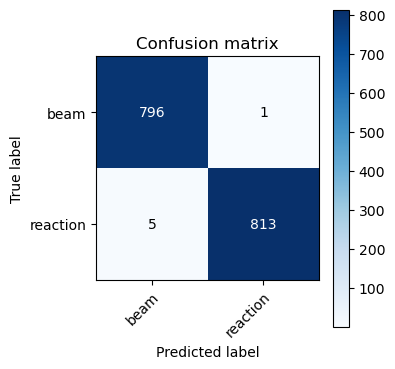


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.7555555555555555
Precision: 1.0
Recall: 0.5
F1-score: 0.6666666666666666
MCC: 0.5815799980377997


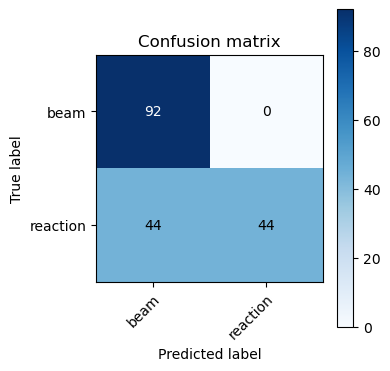

In [21]:
nclusters = 5
clust5 = KMeans(n_clusters=nclusters).fit(xSimple_train_stsc)
#print(clust5.labels_)
KM5_pred_train = clust5.predict(xSimple_train_stsc)
KM5_pred_val = clust5.predict(xSimple_val_stsc)

#Now we need to find out which cluster is which type of event
#We select the one that gives best accuracy on training set
#for this we loop over all combinations without trivial ones (all beam or all reaction)
#we denote accuracy_train_01010 if cluster 0->0, 1->1, 2->0, 3->1 and 4->1

KM5_pred_train_00001 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00010 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00011 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00100 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00101 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00110 = np.zeros(len(KM5_pred_train))
KM5_pred_train_00111 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01000 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01001 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01010 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01011 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01100 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01101 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01110 = np.zeros(len(KM5_pred_train))
KM5_pred_train_01111 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10000 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10001 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10010 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10011 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10100 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10101 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10110 = np.zeros(len(KM5_pred_train))
KM5_pred_train_10111 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11000 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11001 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11010 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11011 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11100 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11101 = np.zeros(len(KM5_pred_train))
KM5_pred_train_11110 = np.zeros(len(KM5_pred_train))

KM5_pred_val_00001 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00010 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00011 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00100 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00101 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00110 = np.zeros(len(KM5_pred_val))
KM5_pred_val_00111 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01000 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01001 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01010 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01011 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01100 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01101 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01110 = np.zeros(len(KM5_pred_val))
KM5_pred_val_01111 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10000 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10001 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10010 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10011 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10100 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10101 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10110 = np.zeros(len(KM5_pred_val))
KM5_pred_val_10111 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11000 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11001 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11010 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11011 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11100 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11101 = np.zeros(len(KM5_pred_val))
KM5_pred_val_11110 = np.zeros(len(KM5_pred_val))

for i in range(len(KM5_pred_train)):
    if (KM5_pred_train[i]==0):
        KM5_pred_train_00001[i] = 0
        KM5_pred_train_00010[i] = 0
        KM5_pred_train_00011[i] = 0
        KM5_pred_train_00100[i] = 0
        KM5_pred_train_00101[i] = 0
        KM5_pred_train_00110[i] = 0
        KM5_pred_train_00111[i] = 0
        KM5_pred_train_01000[i] = 0
        KM5_pred_train_01001[i] = 0
        KM5_pred_train_01010[i] = 0
        KM5_pred_train_01011[i] = 0
        KM5_pred_train_01100[i] = 0
        KM5_pred_train_01101[i] = 0
        KM5_pred_train_01110[i] = 0
        KM5_pred_train_01111[i] = 0
        KM5_pred_train_10000[i] = 1
        KM5_pred_train_10001[i] = 1
        KM5_pred_train_10010[i] = 1
        KM5_pred_train_10011[i] = 1
        KM5_pred_train_10100[i] = 1
        KM5_pred_train_10101[i] = 1
        KM5_pred_train_10110[i] = 1
        KM5_pred_train_10111[i] = 1
        KM5_pred_train_11000[i] = 1
        KM5_pred_train_11001[i] = 1
        KM5_pred_train_11010[i] = 1
        KM5_pred_train_11011[i] = 1
        KM5_pred_train_11100[i] = 1
        KM5_pred_train_11101[i] = 1
        KM5_pred_train_11110[i] = 1
    if (KM5_pred_train[i]==1):
        KM5_pred_train_00001[i] = 0
        KM5_pred_train_00010[i] = 0
        KM5_pred_train_00011[i] = 0
        KM5_pred_train_00100[i] = 0
        KM5_pred_train_00101[i] = 0
        KM5_pred_train_00110[i] = 0
        KM5_pred_train_00111[i] = 0
        KM5_pred_train_01000[i] = 1
        KM5_pred_train_01001[i] = 1
        KM5_pred_train_01010[i] = 1
        KM5_pred_train_01011[i] = 1
        KM5_pred_train_01100[i] = 1
        KM5_pred_train_01101[i] = 1
        KM5_pred_train_01110[i] = 1
        KM5_pred_train_01111[i] = 1
        KM5_pred_train_10000[i] = 0
        KM5_pred_train_10001[i] = 0
        KM5_pred_train_10010[i] = 0
        KM5_pred_train_10011[i] = 0
        KM5_pred_train_10100[i] = 0
        KM5_pred_train_10101[i] = 0
        KM5_pred_train_10110[i] = 0
        KM5_pred_train_10111[i] = 0
        KM5_pred_train_11000[i] = 1
        KM5_pred_train_11001[i] = 1
        KM5_pred_train_11010[i] = 1
        KM5_pred_train_11011[i] = 1
        KM5_pred_train_11100[i] = 1
        KM5_pred_train_11101[i] = 1
        KM5_pred_train_11110[i] = 1
    if (KM5_pred_train[i]==2):
        KM5_pred_train_00001[i] = 0
        KM5_pred_train_00010[i] = 0
        KM5_pred_train_00011[i] = 0
        KM5_pred_train_00100[i] = 1
        KM5_pred_train_00101[i] = 1
        KM5_pred_train_00110[i] = 1
        KM5_pred_train_00111[i] = 1
        KM5_pred_train_01000[i] = 0
        KM5_pred_train_01001[i] = 0
        KM5_pred_train_01010[i] = 0
        KM5_pred_train_01011[i] = 0
        KM5_pred_train_01100[i] = 1
        KM5_pred_train_01101[i] = 1
        KM5_pred_train_01110[i] = 1
        KM5_pred_train_01111[i] = 1
        KM5_pred_train_10000[i] = 0
        KM5_pred_train_10001[i] = 0
        KM5_pred_train_10010[i] = 0
        KM5_pred_train_10011[i] = 0
        KM5_pred_train_10100[i] = 1
        KM5_pred_train_10101[i] = 1
        KM5_pred_train_10110[i] = 1
        KM5_pred_train_10111[i] = 1
        KM5_pred_train_11000[i] = 0
        KM5_pred_train_11001[i] = 0
        KM5_pred_train_11010[i] = 0
        KM5_pred_train_11011[i] = 0
        KM5_pred_train_11100[i] = 1
        KM5_pred_train_11101[i] = 1
        KM5_pred_train_11110[i] = 1
    if (KM5_pred_train[i]==3):
        KM5_pred_train_00001[i] = 0
        KM5_pred_train_00010[i] = 1
        KM5_pred_train_00011[i] = 1
        KM5_pred_train_00100[i] = 0
        KM5_pred_train_00101[i] = 0
        KM5_pred_train_00110[i] = 1
        KM5_pred_train_00111[i] = 1
        KM5_pred_train_01000[i] = 0
        KM5_pred_train_01001[i] = 0
        KM5_pred_train_01010[i] = 1
        KM5_pred_train_01011[i] = 1
        KM5_pred_train_01100[i] = 0
        KM5_pred_train_01101[i] = 0
        KM5_pred_train_01110[i] = 1
        KM5_pred_train_01111[i] = 1
        KM5_pred_train_10000[i] = 0
        KM5_pred_train_10001[i] = 0
        KM5_pred_train_10010[i] = 1
        KM5_pred_train_10011[i] = 1
        KM5_pred_train_10100[i] = 0
        KM5_pred_train_10101[i] = 0
        KM5_pred_train_10110[i] = 1
        KM5_pred_train_10111[i] = 1
        KM5_pred_train_11000[i] = 0
        KM5_pred_train_11001[i] = 0
        KM5_pred_train_11010[i] = 1
        KM5_pred_train_11011[i] = 1
        KM5_pred_train_11100[i] = 0
        KM5_pred_train_11101[i] = 0
        KM5_pred_train_11110[i] = 1
    if (KM5_pred_train[i]==4):
        KM5_pred_train_00001[i] = 1
        KM5_pred_train_00010[i] = 0
        KM5_pred_train_00011[i] = 1
        KM5_pred_train_00100[i] = 0
        KM5_pred_train_00101[i] = 1
        KM5_pred_train_00110[i] = 0
        KM5_pred_train_00111[i] = 1
        KM5_pred_train_01000[i] = 0
        KM5_pred_train_01001[i] = 1
        KM5_pred_train_01010[i] = 0
        KM5_pred_train_01011[i] = 1
        KM5_pred_train_01100[i] = 0
        KM5_pred_train_01101[i] = 1
        KM5_pred_train_01110[i] = 0
        KM5_pred_train_01111[i] = 1
        KM5_pred_train_10000[i] = 0
        KM5_pred_train_10001[i] = 1
        KM5_pred_train_10010[i] = 0
        KM5_pred_train_10011[i] = 1
        KM5_pred_train_10100[i] = 0
        KM5_pred_train_10101[i] = 1
        KM5_pred_train_10110[i] = 0
        KM5_pred_train_10111[i] = 1
        KM5_pred_train_11000[i] = 0
        KM5_pred_train_11001[i] = 1
        KM5_pred_train_11010[i] = 0
        KM5_pred_train_11011[i] = 1
        KM5_pred_train_11100[i] = 0
        KM5_pred_train_11101[i] = 1
        KM5_pred_train_11110[i] = 0
        
for i in range(len(KM5_pred_val)):
    if (KM5_pred_val[i]==0):
        KM5_pred_val_00001[i] = 0
        KM5_pred_val_00010[i] = 0
        KM5_pred_val_00011[i] = 0
        KM5_pred_val_00100[i] = 0
        KM5_pred_val_00101[i] = 0
        KM5_pred_val_00110[i] = 0
        KM5_pred_val_00111[i] = 0
        KM5_pred_val_01000[i] = 0
        KM5_pred_val_01001[i] = 0
        KM5_pred_val_01010[i] = 0
        KM5_pred_val_01011[i] = 0
        KM5_pred_val_01100[i] = 0
        KM5_pred_val_01101[i] = 0
        KM5_pred_val_01110[i] = 0
        KM5_pred_val_01111[i] = 0
        KM5_pred_val_10000[i] = 1
        KM5_pred_val_10001[i] = 1
        KM5_pred_val_10010[i] = 1
        KM5_pred_val_10011[i] = 1
        KM5_pred_val_10100[i] = 1
        KM5_pred_val_10101[i] = 1
        KM5_pred_val_10110[i] = 1
        KM5_pred_val_10111[i] = 1
        KM5_pred_val_11000[i] = 1
        KM5_pred_val_11001[i] = 1
        KM5_pred_val_11010[i] = 1
        KM5_pred_val_11011[i] = 1
        KM5_pred_val_11100[i] = 1
        KM5_pred_val_11101[i] = 1
        KM5_pred_val_11110[i] = 1
    if (KM5_pred_train[i]==1):
        KM5_pred_val_00001[i] = 0
        KM5_pred_val_00010[i] = 0
        KM5_pred_val_00011[i] = 0
        KM5_pred_val_00100[i] = 0
        KM5_pred_val_00101[i] = 0
        KM5_pred_val_00110[i] = 0
        KM5_pred_val_00111[i] = 0
        KM5_pred_val_01000[i] = 1
        KM5_pred_val_01001[i] = 1
        KM5_pred_val_01010[i] = 1
        KM5_pred_val_01011[i] = 1
        KM5_pred_val_01100[i] = 1
        KM5_pred_val_01101[i] = 1
        KM5_pred_val_01110[i] = 1
        KM5_pred_val_01111[i] = 1
        KM5_pred_val_10000[i] = 0
        KM5_pred_val_10001[i] = 0
        KM5_pred_val_10010[i] = 0
        KM5_pred_val_10011[i] = 0
        KM5_pred_val_10100[i] = 0
        KM5_pred_val_10101[i] = 0
        KM5_pred_val_10110[i] = 0
        KM5_pred_val_10111[i] = 0
        KM5_pred_val_11000[i] = 1
        KM5_pred_val_11001[i] = 1
        KM5_pred_val_11010[i] = 1
        KM5_pred_val_11011[i] = 1
        KM5_pred_val_11100[i] = 1
        KM5_pred_val_11101[i] = 1
        KM5_pred_val_11110[i] = 1
    if (KM5_pred_train[i]==2):
        KM5_pred_val_00001[i] = 0
        KM5_pred_val_00010[i] = 0
        KM5_pred_val_00011[i] = 0
        KM5_pred_val_00100[i] = 1
        KM5_pred_val_00101[i] = 1
        KM5_pred_val_00110[i] = 1
        KM5_pred_val_00111[i] = 1
        KM5_pred_val_01000[i] = 0
        KM5_pred_val_01001[i] = 0
        KM5_pred_val_01010[i] = 0
        KM5_pred_val_01011[i] = 0
        KM5_pred_val_01100[i] = 1
        KM5_pred_val_01101[i] = 1
        KM5_pred_val_01110[i] = 1
        KM5_pred_val_01111[i] = 1
        KM5_pred_val_10000[i] = 0
        KM5_pred_val_10001[i] = 0
        KM5_pred_val_10010[i] = 0
        KM5_pred_val_10011[i] = 0
        KM5_pred_val_10100[i] = 1
        KM5_pred_val_10101[i] = 1
        KM5_pred_val_10110[i] = 1
        KM5_pred_val_10111[i] = 1
        KM5_pred_val_11000[i] = 0
        KM5_pred_val_11001[i] = 0
        KM5_pred_val_11010[i] = 0
        KM5_pred_val_11011[i] = 0
        KM5_pred_val_11100[i] = 1
        KM5_pred_val_11101[i] = 1
        KM5_pred_val_11110[i] = 1
    if (KM5_pred_train[i]==3):
        KM5_pred_val_00001[i] = 0
        KM5_pred_val_00010[i] = 1
        KM5_pred_val_00011[i] = 1
        KM5_pred_val_00100[i] = 0
        KM5_pred_val_00101[i] = 0
        KM5_pred_val_00110[i] = 1
        KM5_pred_val_00111[i] = 1
        KM5_pred_val_01000[i] = 0
        KM5_pred_val_01001[i] = 0
        KM5_pred_val_01010[i] = 1
        KM5_pred_val_01011[i] = 1
        KM5_pred_val_01100[i] = 0
        KM5_pred_val_01101[i] = 0
        KM5_pred_val_01110[i] = 1
        KM5_pred_val_01111[i] = 1
        KM5_pred_val_10000[i] = 0
        KM5_pred_val_10001[i] = 0
        KM5_pred_val_10010[i] = 1
        KM5_pred_val_10011[i] = 1
        KM5_pred_val_10100[i] = 0
        KM5_pred_val_10101[i] = 0
        KM5_pred_val_10110[i] = 1
        KM5_pred_val_10111[i] = 1
        KM5_pred_val_11000[i] = 0
        KM5_pred_val_11001[i] = 0
        KM5_pred_val_11010[i] = 1
        KM5_pred_val_11011[i] = 1
        KM5_pred_val_11100[i] = 0
        KM5_pred_val_11101[i] = 0
        KM5_pred_val_11110[i] = 1
    if (KM5_pred_train[i]==4):
        KM5_pred_val_00001[i] = 1
        KM5_pred_val_00010[i] = 0
        KM5_pred_val_00011[i] = 1
        KM5_pred_val_00100[i] = 0
        KM5_pred_val_00101[i] = 1
        KM5_pred_val_00110[i] = 0
        KM5_pred_val_00111[i] = 1
        KM5_pred_val_01000[i] = 0
        KM5_pred_val_01001[i] = 1
        KM5_pred_val_01010[i] = 0
        KM5_pred_val_01011[i] = 1
        KM5_pred_val_01100[i] = 0
        KM5_pred_val_01101[i] = 1
        KM5_pred_val_01110[i] = 0
        KM5_pred_val_01111[i] = 1
        KM5_pred_val_10000[i] = 0
        KM5_pred_val_10001[i] = 1
        KM5_pred_val_10010[i] = 0
        KM5_pred_val_10011[i] = 1
        KM5_pred_val_10100[i] = 0
        KM5_pred_val_10101[i] = 1
        KM5_pred_val_10110[i] = 0
        KM5_pred_val_10111[i] = 1
        KM5_pred_val_11000[i] = 0
        KM5_pred_val_11001[i] = 1
        KM5_pred_val_11010[i] = 0
        KM5_pred_val_11011[i] = 1
        KM5_pred_val_11100[i] = 0
        KM5_pred_val_11101[i] = 1
        KM5_pred_val_11110[i] = 0
        

        
        

accuracy_train_00001 = accuracy_score(Labels_train, KM5_pred_train_00001)
accuracy_train_00010 = accuracy_score(Labels_train, KM5_pred_train_00010)
accuracy_train_00011 = accuracy_score(Labels_train, KM5_pred_train_00011)
accuracy_train_00100 = accuracy_score(Labels_train, KM5_pred_train_00100)
accuracy_train_00101 = accuracy_score(Labels_train, KM5_pred_train_00101)
accuracy_train_00110 = accuracy_score(Labels_train, KM5_pred_train_00110)
accuracy_train_00111 = accuracy_score(Labels_train, KM5_pred_train_00111)
accuracy_train_01000 = accuracy_score(Labels_train, KM5_pred_train_01000)
accuracy_train_01001 = accuracy_score(Labels_train, KM5_pred_train_01001)
accuracy_train_01010 = accuracy_score(Labels_train, KM5_pred_train_01010)
accuracy_train_01011 = accuracy_score(Labels_train, KM5_pred_train_01011)
accuracy_train_01100 = accuracy_score(Labels_train, KM5_pred_train_01100)
accuracy_train_01101 = accuracy_score(Labels_train, KM5_pred_train_01101)
accuracy_train_01110 = accuracy_score(Labels_train, KM5_pred_train_01110)
accuracy_train_01111 = accuracy_score(Labels_train, KM5_pred_train_01111)
accuracy_train_10000 = accuracy_score(Labels_train, KM5_pred_train_10000)
accuracy_train_10001 = accuracy_score(Labels_train, KM5_pred_train_10001)
accuracy_train_10010 = accuracy_score(Labels_train, KM5_pred_train_10010)
accuracy_train_10011 = accuracy_score(Labels_train, KM5_pred_train_10011)
accuracy_train_10100 = accuracy_score(Labels_train, KM5_pred_train_10100)
accuracy_train_10101 = accuracy_score(Labels_train, KM5_pred_train_10101)
accuracy_train_10110 = accuracy_score(Labels_train, KM5_pred_train_10110)
accuracy_train_10111 = accuracy_score(Labels_train, KM5_pred_train_10111)
accuracy_train_11000 = accuracy_score(Labels_train, KM5_pred_train_11000)
accuracy_train_11001 = accuracy_score(Labels_train, KM5_pred_train_11001)
accuracy_train_11010 = accuracy_score(Labels_train, KM5_pred_train_11010)
accuracy_train_11011 = accuracy_score(Labels_train, KM5_pred_train_11011)
accuracy_train_11100 = accuracy_score(Labels_train, KM5_pred_train_11100)
accuracy_train_11101 = accuracy_score(Labels_train, KM5_pred_train_11101)
accuracy_train_11110 = accuracy_score(Labels_train, KM5_pred_train_11110)

f1_train_00001 = f1_score(Labels_train, KM5_pred_train_00001)
f1_train_00010 = f1_score(Labels_train, KM5_pred_train_00010)
f1_train_00011 = f1_score(Labels_train, KM5_pred_train_00011)
f1_train_00100 = f1_score(Labels_train, KM5_pred_train_00100)
f1_train_00101 = f1_score(Labels_train, KM5_pred_train_00101)
f1_train_00110 = f1_score(Labels_train, KM5_pred_train_00110)
f1_train_00111 = f1_score(Labels_train, KM5_pred_train_00111)
f1_train_01000 = f1_score(Labels_train, KM5_pred_train_01000)
f1_train_01001 = f1_score(Labels_train, KM5_pred_train_01001)
f1_train_01010 = f1_score(Labels_train, KM5_pred_train_01010)
f1_train_01011 = f1_score(Labels_train, KM5_pred_train_01011)
f1_train_01100 = f1_score(Labels_train, KM5_pred_train_01100)
f1_train_01101 = f1_score(Labels_train, KM5_pred_train_01101)
f1_train_01110 = f1_score(Labels_train, KM5_pred_train_01110)
f1_train_01111 = f1_score(Labels_train, KM5_pred_train_01111)
f1_train_10000 = f1_score(Labels_train, KM5_pred_train_10000)
f1_train_10001 = f1_score(Labels_train, KM5_pred_train_10001)
f1_train_10010 = f1_score(Labels_train, KM5_pred_train_10010)
f1_train_10011 = f1_score(Labels_train, KM5_pred_train_10011)
f1_train_10100 = f1_score(Labels_train, KM5_pred_train_10100)
f1_train_10101 = f1_score(Labels_train, KM5_pred_train_10101)
f1_train_10110 = f1_score(Labels_train, KM5_pred_train_10110)
f1_train_10111 = f1_score(Labels_train, KM5_pred_train_10111)
f1_train_11000 = f1_score(Labels_train, KM5_pred_train_11000)
f1_train_11001 = f1_score(Labels_train, KM5_pred_train_11001)
f1_train_11010 = f1_score(Labels_train, KM5_pred_train_11010)
f1_train_11011 = f1_score(Labels_train, KM5_pred_train_11011)
f1_train_11100 = f1_score(Labels_train, KM5_pred_train_11100)
f1_train_11101 = f1_score(Labels_train, KM5_pred_train_11101)
f1_train_11110 = f1_score(Labels_train, KM5_pred_train_11110)

KM5_tr_acc_list = [accuracy_train_00001, accuracy_train_00010, accuracy_train_00011, accuracy_train_00100, 
                   accuracy_train_00101, accuracy_train_00110, accuracy_train_00111, accuracy_train_01000, 
                   accuracy_train_01001, accuracy_train_01010, 
                   accuracy_train_01011, accuracy_train_01100, accuracy_train_01101, accuracy_train_01110, 
                   accuracy_train_01111,
                   accuracy_train_10000, accuracy_train_10001, accuracy_train_10010, accuracy_train_10011, 
                   accuracy_train_10100, accuracy_train_10101, accuracy_train_10110, accuracy_train_10111,
                   accuracy_train_11000, accuracy_train_11001, accuracy_train_11010, 
                   accuracy_train_11011, accuracy_train_11100, 
                   accuracy_train_11101, accuracy_train_11110]

print(KM5_tr_acc_list)

KM5_tr_f1_list = [f1_train_00001, f1_train_00010, f1_train_00011, f1_train_00100, 
                   f1_train_00101, f1_train_00110, f1_train_00111, f1_train_01000, 
                   f1_train_01001, f1_train_01010, 
                   f1_train_01011, f1_train_01100, f1_train_01101, f1_train_01110, 
                   f1_train_01111,
                   f1_train_10000, f1_train_10001, f1_train_10010, f1_train_10011, 
                   f1_train_10100, f1_train_10101, f1_train_10110, f1_train_10111,
                   f1_train_11000, f1_train_11001, f1_train_11010, 
                   f1_train_11011, f1_train_11100, 
                   f1_train_11101, f1_train_11110]

KM5_pred_train_list = [KM5_pred_train_00001, KM5_pred_train_00010, KM5_pred_train_00011, KM5_pred_train_00100, 
                   KM5_pred_train_00101, KM5_pred_train_00110, KM5_pred_train_00111, KM5_pred_train_01000, 
                   KM5_pred_train_01001, KM5_pred_train_01010, 
                   KM5_pred_train_01011, KM5_pred_train_01100, KM5_pred_train_01101, KM5_pred_train_01110, 
                   KM5_pred_train_01111,
                   KM5_pred_train_10000, KM5_pred_train_10001, KM5_pred_train_10010, KM5_pred_train_10011, 
                   KM5_pred_train_10100, KM5_pred_train_10101, KM5_pred_train_10110, KM5_pred_train_10111,
                   KM5_pred_train_11000, KM5_pred_train_11001, KM5_pred_train_11010, 
                   KM5_pred_train_11011, KM5_pred_train_11100, 
                   KM5_pred_train_11101, KM5_pred_train_11110]

KM5_pred_val_list = [KM5_pred_val_00001, KM5_pred_val_00010, KM5_pred_val_00011, KM5_pred_val_00100, 
                   KM5_pred_val_00101, KM5_pred_val_00110, KM5_pred_val_00111, KM5_pred_val_01000, 
                   KM5_pred_val_01001, KM5_pred_val_01010, 
                   KM5_pred_val_01011, KM5_pred_val_01100, KM5_pred_val_01101, KM5_pred_val_01110, 
                   KM5_pred_val_01111,
                   KM5_pred_val_10000, KM5_pred_val_10001, KM5_pred_val_10010, KM5_pred_val_10011, 
                   KM5_pred_val_10100, KM5_pred_val_10101, KM5_pred_val_10110, KM5_pred_val_10111,
                   KM5_pred_val_11000, KM5_pred_val_11001, KM5_pred_val_11010, 
                   KM5_pred_val_11011, KM5_pred_val_11100, 
                   KM5_pred_val_11101, KM5_pred_val_11110]

#Finds best accuracy model
max_accuracy_KM5_train = max(KM5_tr_acc_list)
max_f1_KM5_train = max(KM5_tr_f1_list)
max_index_KM5 = KM5_tr_acc_list.index(max_accuracy_KM5_train)

KM5_pred_train = KM5_pred_train_list[max_index_KM5]
KM5_pred_val = KM5_pred_val_list[max_index_KM5]
    

    

accuracy_train = accuracy_score(Labels_train, KM5_pred_train)
confmat_train = confusion_matrix(Labels_train, KM5_pred_train)
f1_train = f1_score(Labels_train, KM5_pred_train)
mcc_train = matthews_corrcoef(Labels_train, KM5_pred_train)

accuracy = accuracy_score(Labels_val, KM5_pred_val)
confmat = confusion_matrix(Labels_val, KM5_pred_val)
f1 = f1_score(Labels_val, KM5_pred_val)
mcc = matthews_corrcoef(Labels_val, KM5_pred_val)

print_model_performance(Labels_train,KM5_pred_train,"training")
print_model_performance(Labels_val,KM5_pred_val,"validation")

### Support Vector Machine
Here we use a support vector machine. As in the random forest case, the optimal parameters are determined using gridsearch.

# Tuning hyper-parameters for recall

Best parameters set found on training set for recall:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on training set:

0.985 (+/-0.021) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.915 (+/-0.033) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.985 (+/-0.021) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 1, 'kernel': 'linear'}
0.997 (+/-0.005) for {'C': 10, 'kernel': 'linear'}
0.997 (+/-0.005) for {'C': 100, 'kernel': 'linear'}
0.997 (+/-0.005) for {'C': 1000, 'kernel': 'linear'}
0.956 (+/-0.027) for {'C': 1, 'coef0': 0.0, 'degree': 2, 'kernel': 'poly'}
0.996 (+/-0.005) for {'C': 1, 'c

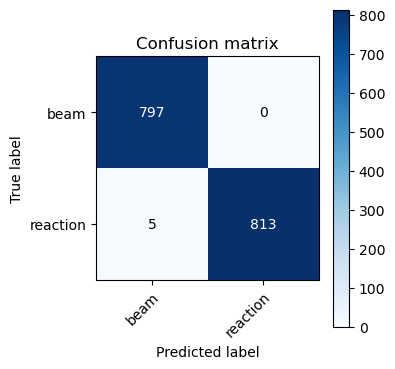


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9944444444444445
Precision: 1.0
Recall: 0.9886363636363636
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


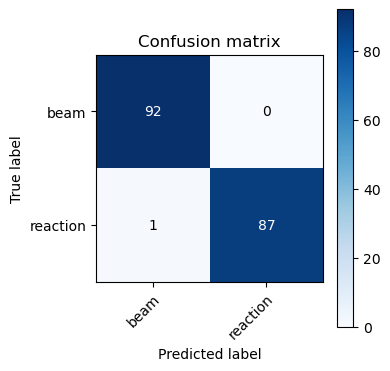

In [22]:
from sklearn.metrics import classification_report
from sklearn import svm

#Simplest method
#SVM = svm.SVC(kernel='rbf') #other options (poly,sigmoid,linear)
#SVM.fit(xSimple_train_stsc,Labels_train)

#SVM_pred_train = SVM.predict(xSimple_train_stsc)
#SVM_pred_val = SVM.predict(xSimple_val_stsc)


#Using grid search



# Set the parameters by cross-validation

#small set of tuning parameters
small_tuned_parameters = [{'kernel': ['poly'], 'C': [1, 10, 100, 1000], 'degree': [2,3,4], 'coef0': [0.,0.01,0.1,0.5]}]

#large set of tuning parameters
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                   {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'C': [1, 10, 100, 1000], 'degree': [2,3,4], 'coef0': [0.,0.01,0.1,0.5,1.5]},
                   {'kernel': ['sigmoid'], 'C': [1, 10, 100, 1000], 'coef0': [0.,0.01,0.1,0.5,1.5]}]

#select a metric to choose best SVM (comment one or the other)

#score = 'precision'
score = 'recall'


print("# Tuning hyper-parameters for %s" % score)
print()

SVM = GridSearchCV(
    svm.SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score
)
SVM.fit(xSimple_train_stsc,Labels_train)

print("Best parameters set found on training set for %s:" % score)
print()
print(SVM.best_params_)
print()
print("Grid scores on training set:")
print()
means = SVM.cv_results_['mean_test_score']
stds = SVM.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, SVM.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()

SVM_pred_train = SVM.predict(xSimple_train_stsc)
SVM_pred_val = SVM.predict(xSimple_val_stsc)

print_model_performance(Labels_train,SVM_pred_train,"training")
print_model_performance(Labels_val,SVM_pred_val,"validation")


### DEMOCRACY
Here we let each method (linear regression, DNN, K-means and Random Forest) vote for the classification

Model performance for training set:
--------------------------------------------------------

Accuracy: 0.9969040247678018
Precision: 1.0
Recall: 0.9938875305623472
F1-score: 0.996934396076027
MCC: 0.9938265564282749


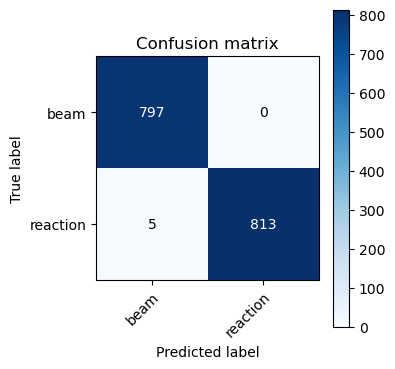


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9944444444444445
Precision: 1.0
Recall: 0.9886363636363636
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


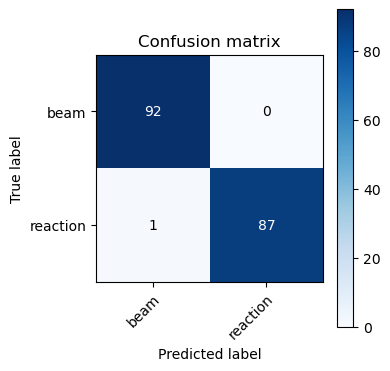

In [23]:
#TotalVotesTrain = DNN_pred_train + KM_pred_train + LR_pred_train + RFC_pred_train
#TotalVotesVal = DNN_pred_val + KM_pred_val + LR_pred_val + RFC_pred_val
Vote_pred_train = np.zeros(len(DNN_pred_train))
Vote_pred_val = np.zeros(len(DNN_pred_val))

#used for making histogram
total_vote_train = np.zeros(len(DNN_pred_train))
total_vote_val = np.zeros(len(DNN_pred_val))

for i in range(len(DNN_pred_train)):
    TotalVotesTrain = DNN_pred_train[i] + KM3_pred_train[i] + LR_pred_train[i] + RFC_pred_train[i] + SVM_pred_train[i]
    total_vote_train[i] = TotalVotesTrain
    if TotalVotesTrain > 2:
        Vote_pred_train[i] = 1
    else:
        Vote_pred_train[i] = 0
for i in range(len(DNN_pred_val)):
    TotalVotesVal = DNN_pred_val[i] + KM3_pred_val[i] + LR_pred_val[i] + RFC_pred_val[i] + SVM_pred_val[i]
    total_vote_val[i] = TotalVotesVal
    if TotalVotesVal > 2:
        Vote_pred_val[i] = 1
    else:
        Vote_pred_val[i] = 0
    
print_model_performance(Labels_train,Vote_pred_train,"training")
print_model_performance(Labels_val,Vote_pred_val,"validation")




### Misclassified Event (training set)
Here we find and plot all events in the training set that were misclassified using the democratic voting above

[1711  499 1237  280 1098]


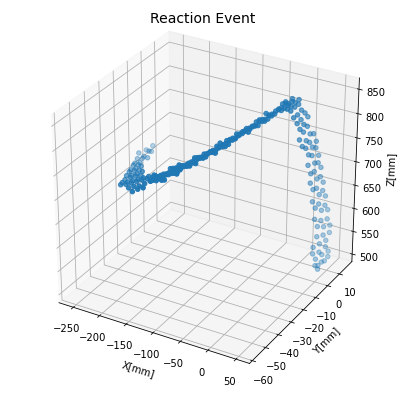

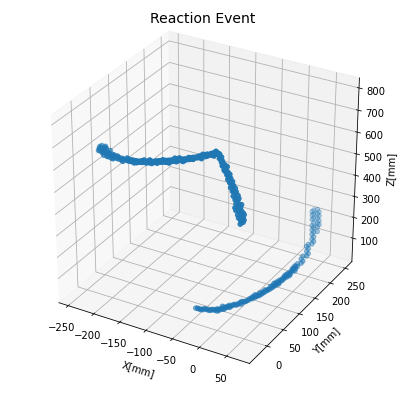

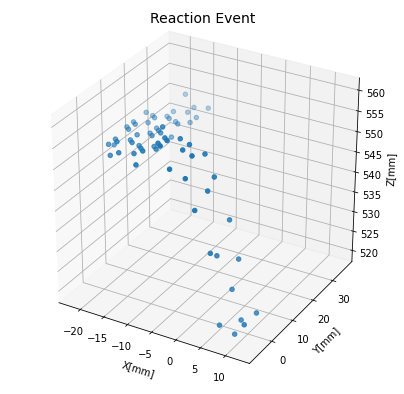

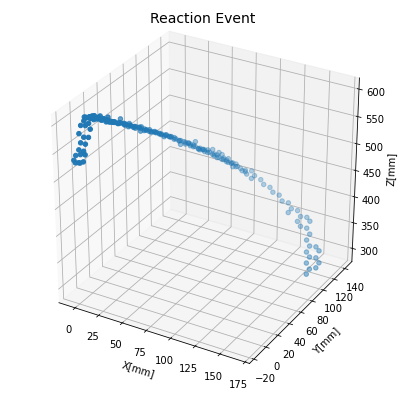

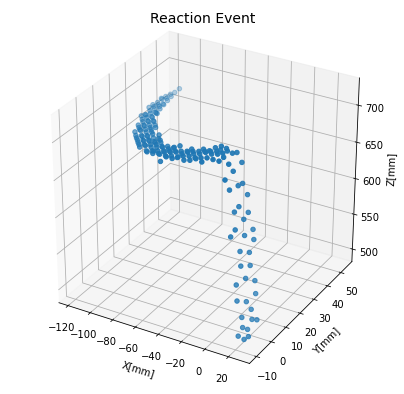

In [24]:
misclassified_events_train = train_idx[Labels_train != Vote_pred_train]

print(misclassified_events_train)

for i in(misclassified_events_train):
    plot_3d_event(AllData,Labels,i)

In [25]:
#data_origin = 'https://github.com/NuclearTalent/MachineLearningECT/raw/master/doc/ProjectsExercises/2020/ProjectAT/pdf/Mg22_alphaalpha_digiSim.h5'

#data_path = tf.keras.utils.get_file('Mg22_alphaalpha_digiSim.h5', origin=data_origin)
#h5 = h5py.File(data_path, 'r')

### Model performance
Some visual comparison of the sklearn methods (logistic, random forest, svm) can be made using a RoC plot.
Altought this doesn't tell much and I'm not sure logistic regression is anything but switch between two cases.

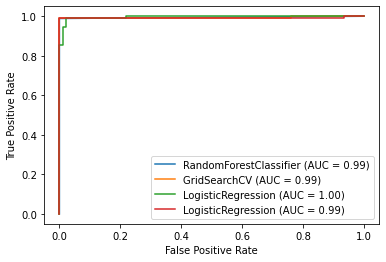

In [26]:
ax = plt.gca()
rfc_roc = plot_roc_curve(RFC_best, xSimple_val_stsc, Labels_val, ax=ax)
svm_roc = plot_roc_curve(SVM, xSimple_val_stsc, Labels_val, ax=ax)
logreg_roc = plot_roc_curve(logreg, xSimple_val, Labels_val, ax=ax)
logreg2_roc = plot_roc_curve(logreg2, xSimple_val_stsc, Labels_val, ax=ax)
plt.show()

### Voting Statistics

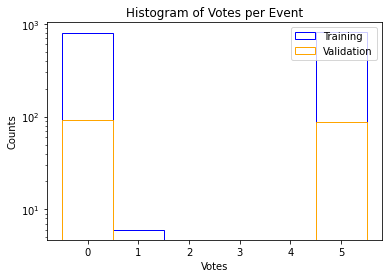

In [27]:

fig = plt.figure()
ax = fig.add_subplot()
ax.hist(total_vote_train, color='blue', bins =[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5], label = 'Training', histtype = 'step')
ax.hist(total_vote_val, color='orange', bins =[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5], label = 'Validation', histtype = 'step')
ax.set_title("Histogram of Votes per Event")
ax.set_xlabel("Votes")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.legend()


We can see the models do vote almost always for the same classification.